# Experiment: use crypto price to predict polymarket share price

As shown in previous plots, there is a relatively high correlation between change in price of cryptocurrency and change in price of polymarket shares. Colleration persists even at a negative offset, meaning that change in crypto has some predictive power over polymarket's share price.

This observation could be used to make trades with polymarket's shares. `When crypto's price grows, buy shares. Wait for some time, and then sell at a usually higher price.`

In [2]:
%config InlineBackend.figure_format = 'png'

from importlib import reload

# load pm data
from datetime import datetime
import poly_api
import poly_datasets


ts_options = poly_api.TSOptions(
    fidelity_in_minutes=3,
    interval_to_load=(
        poly_datasets.all_markets[0].date_from,
        poly_datasets.all_markets[0].date_to,
    ),
)
raw_markets = poly_api.load_markets_data(
    poly_datasets.all_markets[0].market_ids, 
    ts_options,)
processed_markets = poly_datasets.process_pm_df(raw_markets)


In [3]:
# load binance data
import binance_datasets


binance_df = binance_datasets.load_matching_binance_data(
    processed_markets, ts_options.fidelity_in_minutes, "BTCUSDT"
)
binance_deltas = [binance_df.loc[market.index, "delta"] for market in processed_markets]

Loading from binance at intervals: from 2025-01-02 19:09:00 until 2025-01-30 21:57:00


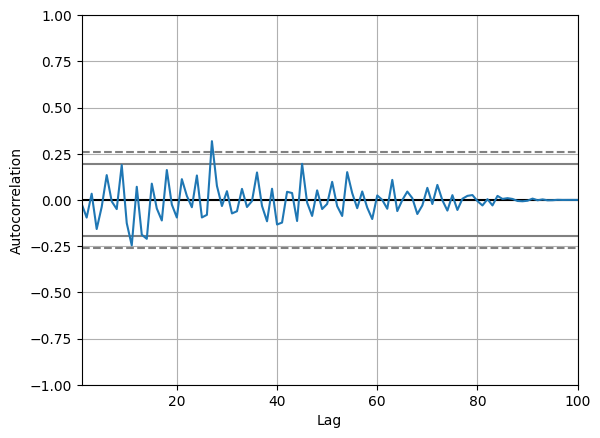

In [4]:
# See if BTC deltas are correlated
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

autocorr = np.correlate(binance_deltas[0], binance_deltas[0], mode="full")

pd.plotting.autocorrelation_plot(autocorr[0:100])
plt.show()

In [5]:
autocorr[0:10]

array([  1482.4   ,   2165.5888,   -838.3488,  -8450.3312,  12934.4128,
        -2031.0984,  10218.6284, -19931.2789, -20280.873 , -27041.6005])

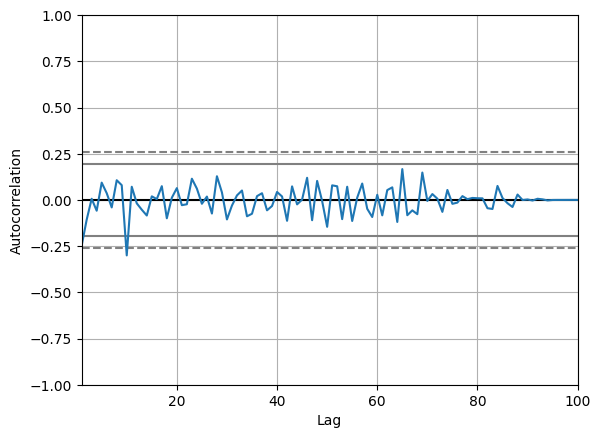

In [5]:
# See if polymarket share deltas are correlated
autocorr = np.correlate(processed_markets[5].delta, processed_markets[5].delta, mode="full")

pd.plotting.autocorrelation_plot(autocorr[0:100])
plt.show()

In [6]:
def trading_func_use_all(
    idx: int,
    shares: np.ndarray,
    binance_delta: np.ndarray,
    traded: np.ndarray,
    poly_close_price: np.ndarray,
    balance: np.ndarray,
    min_delta: float,
    transaction_fee: float,
):
    btc_price_grew = binance_delta[idx] > min_delta
    holding_shares = shares[idx - 1] > 0

    if not holding_shares:
        if btc_price_grew:
            # Buy shares
            spend = balance[idx - 1]
            spend_on_shares = spend - transaction_fee
            shares[idx] = spend_on_shares / poly_close_price[idx]
            balance[idx] = balance[idx - 1] - spend
            traded[idx] = True

    elif holding_shares:
        # Sell shares
        aquired_balance = shares[idx - 1] * poly_close_price[idx]
        balance[idx] = balance[idx - 1] + aquired_balance - transaction_fee
        shares[idx] = 0
        traded[idx] = True

    # If a new balance was not set, keep the previous one
    if not traded[idx]:
        balance[idx] = balance[idx - 1]
        shares[idx] = shares[idx - 1]


def trading_func_use_capped(
    idx: int,
    shares: np.ndarray,
    binance_delta: np.ndarray,
    traded: np.ndarray,
    poly_close_price: np.ndarray,
    balance: np.ndarray,
    min_delta: float,
    transaction_fee: float,
    purchase_cap: float = 100,
):
    btc_price_grew = binance_delta[idx] > min_delta
    holding_shares = shares[idx - 1] > 0

    if not holding_shares:
        if btc_price_grew:
            # Buy shares
            spend = min(purchase_cap + transaction_fee, balance[idx - 1])
            spend_on_shares = spend - transaction_fee
            shares[idx] = spend_on_shares / poly_close_price[idx]
            balance[idx] = balance[idx - 1] - spend
            traded[idx] = True

    elif holding_shares:
        # Sell shares
        balance[idx] = (
            balance[idx - 1]
            + (shares[idx - 1] * poly_close_price[idx])
            - transaction_fee
        )
        shares[idx] = 0
        traded[idx] = True

    # If a new balance was not set, keep the previous one
    if not traded[idx]:
        balance[idx] = balance[idx - 1]
        shares[idx] = shares[idx - 1]


def simulate_trading(
    poly_close_price: np.ndarray,
    binance_delta: pd.Series,
    starting_balance=100,
    min_delta=30,
    transaction_fee=0.0,
):
    # Add an extra item at the beginning to simplify indexing
    poly_price = np.concat((np.array([poly_close_price[0]]), poly_close_price))
    binance_delta = np.concat(([0], binance_delta.to_numpy()))

    # TODO: My trades can influence the market. Add some cap to the amount of shares I can buy/sell?
    # TODO: Not all my shares can get bought. Account for that too.
    # TODO: Does it make sense to look at consecutive change of BTC price?
    #       Datapoints where BTC grew 2+ consecutive intervals at a time?
    balance = np.zeros(len(poly_price)) * np.nan
    shares = np.zeros(len(poly_price)) * np.nan
    traded = np.zeros(len(poly_price))

    balance[0] = starting_balance
    shares[0] = 0

    idx = 1
    while idx < (len(poly_price) - 1):
        trading_func_use_capped(
            idx,
            shares,
            binance_delta,
            traded,
            poly_price,
            balance,
            min_delta,
            transaction_fee,
        )
        idx += 1

    # Set the last balance and shares to some value (NaN by default)
    balance[idx] = balance[idx - 1]

    # If has shares at the end, sell them all
    if shares[idx] > 0:
        aquired_balance = shares[idx] * poly_price[idx - 1]
        balance[idx] = balance[idx - 1] + aquired_balance - transaction_fee
        shares[idx] = 0
        traded[idx] = True
    else:
        shares[idx] = shares[idx - 1]

    actives = balance + (shares * poly_price)
    actives_end = actives[1:]
    actives_start = actives[:-1]
    actives_delta = actives_end - actives_start
    actives_delta_percentage = actives_delta / actives_start

    trades_made = np.sum(traded)
    total_fees = transaction_fee * trades_made
    return {
        "actives_start": actives[0],
        "actives_end": round(float(actives[idx]), 4),
        "actives": actives,
        "actives_delta": actives_delta,
        "actives_delta_percentage": actives_delta_percentage,
        "actives_won_lost": (
            round(float(sum(actives_delta[actives_delta > 0])), 4),
            round(float(sum(actives_delta[actives_delta < 0])), 4),
        ),
        "trades_made": trades_made,
        "trades_won_lost": (
            int(sum(actives_delta > 0)),
            int(sum(actives_delta < 0)),
        ),
        "trade_fees": round(total_fees, 4),
        "trade_descisions_made": len(poly_price),
    }


def print_result(result: dict):
    for key, value in result.items():
        if not isinstance(value, np.ndarray):
            print(f"{key}: {value}")

In [10]:
def symmetric_ylim(x):
    max_val = max(abs(x))
    return -max_val * 1.1, max_val * 1.1


def plot_result(result: dict):
    actives: np.ndarray = result["actives"]
    actives_delta = result["actives_delta"]
    actives_delta_percentage = result["actives_delta_percentage"]

    print_result(result)

    fig, axs = plt.subplots(2, 1, figsize=(5, 6))

    axs[0].plot(actives)
    axs[0].set_title("Actives")
    axs[0].set_xlabel("Trade Index")

    axs[1].plot(actives_delta_percentage)
    axs[1].set_title("Actives Delta in Percentage")
    axs[1].set_xlabel("Trade Index")
    axs[1].set_ylim(symmetric_ylim(actives_delta_percentage))

    plt.tight_layout()
    plt.show()

will-bitcoin-reach-120000-by-january-31-2025
actives_start: 100.0
actives_end: 1001.9288
actives_won_lost: (2757.6457, -1855.7168)
trades_made: 8318.0
trades_won_lost: (473, 7845)
trade_fees: 21.6268
trade_descisions_made: 13494


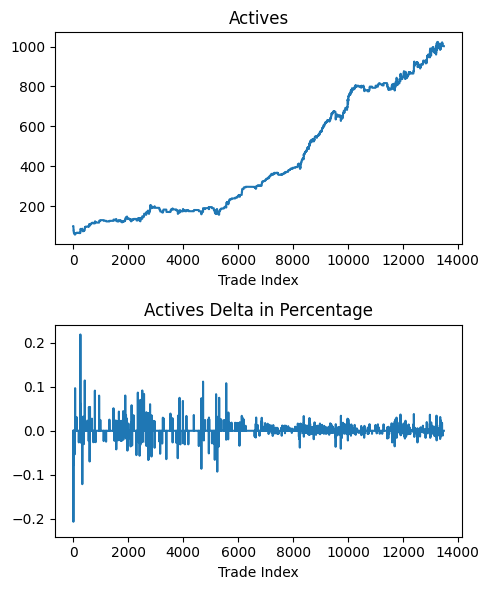

In [15]:
market_data = processed_markets[4]
binance_delta = binance_deltas[4]

print(market_data.label)
result = simulate_trading(
    market_data.close,
    binance_delta,
    starting_balance=100,
    min_delta=10,
    transaction_fee=0.0026,
)
plot_result(result)

Label: will-bitcoin-reach-105000-by-january-31-2025
actives_start: 100.0
actives_end: 350.5655
actives_won_lost: (441.6148, -191.0493)
trades_made: 1850.0
trades_won_lost: (233, 1617)
trade_fees: 4.81
trade_descisions_made: 7195


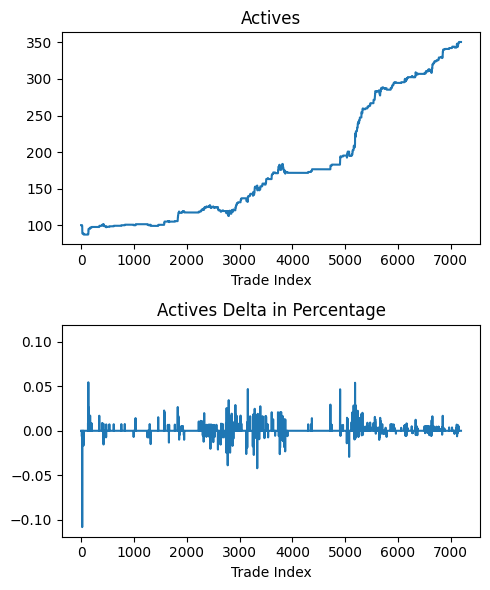

In [16]:
market_data = processed_markets[6]
binance_delta = binance_deltas[6]

print("Label:", market_data.label)
result = simulate_trading(
    market_data.close,
    binance_delta,
    starting_balance=100,
    min_delta=80,
    transaction_fee=0.0026,
)
plot_result(result)

In [17]:
from pprint import pprint


def probe_deltas(market_data, binance_delta):
    results = []
    for min_delta in [5, 10, 20, 40, 80, 120, 200, 300]:
        result = simulate_trading(
            market_data.close,
            binance_delta,
            starting_balance=100,
            min_delta=min_delta,
            transaction_fee=0.0026,
        )
        results.append((min_delta, result["actives_end"]))
    return results

# for idx in range(len(processed_markets)):
#     print("Market:", processed_markets[idx].label)
#     pprint(probe_deltas(processed_markets[idx], binance_deltas[idx]))

In [18]:
def probe_intervals(market_data, binance_delta, min_delta, interval_size=1000):
    results = []

    i1 = 0
    i2 = interval_size
    il = len(market_data.close) - 1
    intervals = [i1] + [i for i in range(i2, il - interval_size, interval_size)] + [il]

    for idx in range(len(intervals) - 1):
        imin, imax = intervals[idx], intervals[idx + 1]
        result = simulate_trading(
            market_data.close[imin:imax],
            binance_delta[imin:imax],
            starting_balance=100,
            min_delta=min_delta,
            transaction_fee=0.0026,
        )
        results.append((imin, result["actives_end"]))
    return results

intevals_probe = probe_intervals(processed_markets[6], binance_deltas[6], 80)

In [80]:
interval_width = 1000

def probe_datasets(markets: list[poly_datasets.PMDataset], binance_deltas: list[np.ndarray]):
    results = {}

    for idx in range(len(markets)):
        results[markets[idx].label] = probe_intervals(markets[idx], binance_deltas[idx], 20, interval_width)
    
    return results

results = probe_datasets(processed_markets, binance_deltas)
results[processed_markets[5].label]

[(0, 87.4601),
 (1000, 129.7103),
 (2000, 150.279),
 (3000, 164.8672),
 (4000, 124.2876),
 (5000, 185.3278),
 (6000, 185.1543),
 (7000, 157.9444),
 (8000, 219.5198),
 (9000, 201.8333),
 (10000, 127.5774),
 (11000, 209.7157),
 (12000, 450.6997)]

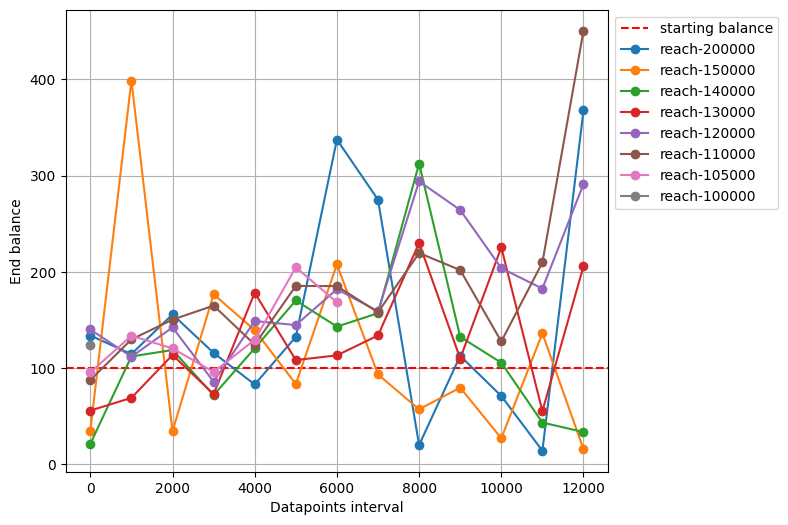

In [83]:

fig, axes = plt.subplots(figsize=(7, 6))

axes.axhline(y=100, color='r', linestyle='--', label="starting balance")

for market in processed_markets:
    if "reach" in market.label:
        x, y = zip(*results[market.label])
        x, y = np.array(x), np.array(y)

        axes.plot(x, y, marker="o", label=market.label[13:-19])

plt.xlabel("Datapoints interval")
plt.ylabel("End balance")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)

plt.show()

In [84]:
starting_balance = 100

end_balance_cnt = {}

for market_label, market_results in results.items():
    if "reach" not in market_label:
        continue
    above_count = sum(
        1 for _, end_balance in market_results if end_balance > starting_balance
    )
    below_count = sum(
        1 for _, end_balance in market_results if end_balance < starting_balance
    )

    total_balance = sum(
        end_balance for _, end_balance in market_results if end_balance
    ) - starting_balance * len(market_results)
    end_balance_cnt[market_label[13:-19]] = {
        "above": above_count,
        "below": below_count,
        "total_profit": round(total_balance, 4),
    }

print("End balance stats:")
pprint(end_balance_cnt)

End balance stats:
{'reach-100000': {'above': 1, 'below': 0, 'total_profit': 23.8487},
 'reach-105000': {'above': 5, 'below': 2, 'total_profit': 247.4581},
 'reach-110000': {'above': 12, 'below': 1, 'total_profit': 1094.3766},
 'reach-120000': {'above': 12, 'below': 1, 'total_profit': 1050.1145},
 'reach-130000': {'above': 9, 'below': 4, 'total_profit': 370.8578},
 'reach-140000': {'above': 9, 'below': 4, 'total_profit': 241.5702},
 'reach-150000': {'above': 5, 'below': 8, 'total_profit': 183.282},
 'reach-200000': {'above': 9, 'below': 4, 'total_profit': 632.8231}}


## Interpretation

On the plot ... is shown. We can see that most of the trading bouts are profitable. When summing up all the trading bouts we can see that they still run a profit.